# Notes on this notebook
    This notebook is to work on solving stokes on a large, coarse mesh and then use that as the boundary condition for fine meshes around the boreholes.

# 0. Import packages

In [1]:
import firedrake
import numpy as np
import pickle as pkl
from numpy import pi as π
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
from IPython.display import HTML
import firedrake
from firedrake import Constant, inner, sqrt, tr, grad, div, as_vector, exp,sym, as_vector, dx, ds, Mesh, Function, project, TransferManager
import meshpy, meshpy.geometry, meshpy.triangle
import irksome
from irksome import Dt
from scipy.signal import detrend
import copy
import matplotlib
import irksome
from irksome import Dt
import matplotlib.pyplot as plt
import pandas as pd
import scipy
import pickle as pkl
import tqdm
import emcee
import corner
import itertools
import xarray
import dtscalibration
import glob
from rasterio.plot import show
import matplotlib.colors as mcolors
import matplotlib.cm as cm
import os
import sys
from pyproj import Transformer
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

from scripts.AH_temp_funcs import *
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
import shapefile as sf

import rasterio
from rasterio.enums import Resampling
from rasterio.mask import mask

%matplotlib widget

# 1.0 Load the DEMs

In [2]:
# Fine DEM

src_bed_fine = rasterio.open("../Meshes/crop_aoi/main_boreholes_aoi/main_boreholes_aoi_fix_bed.tif")
src_surf_fine = rasterio.open("../Meshes/crop_aoi/main_boreholes_aoi/main_boreholes_aoi_fix_surf.tif")

# Course DEM

src_bed_coarse = rasterio.open("../Meshes/ThreeD_meshing/bedmachine_ian_merged_bed_large_aoi_8m_aligned_fixed.tif")
src_surf_coarse = rasterio.open("../Meshes/ThreeD_meshing/rema_large_aoi_align_fixed.tif")

## 1.0.1 Resample the DEMs to desired resolution

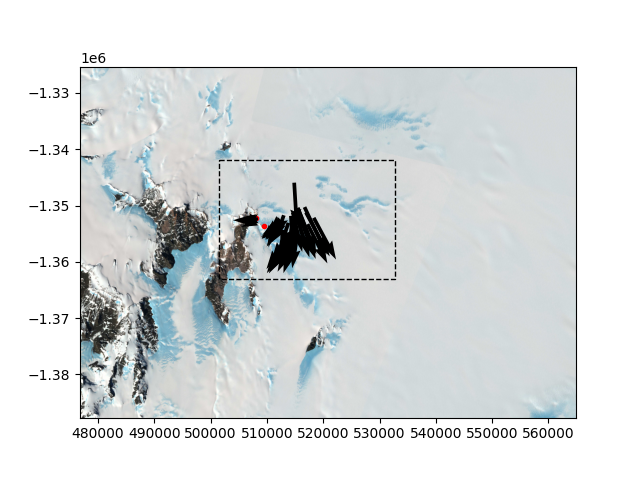

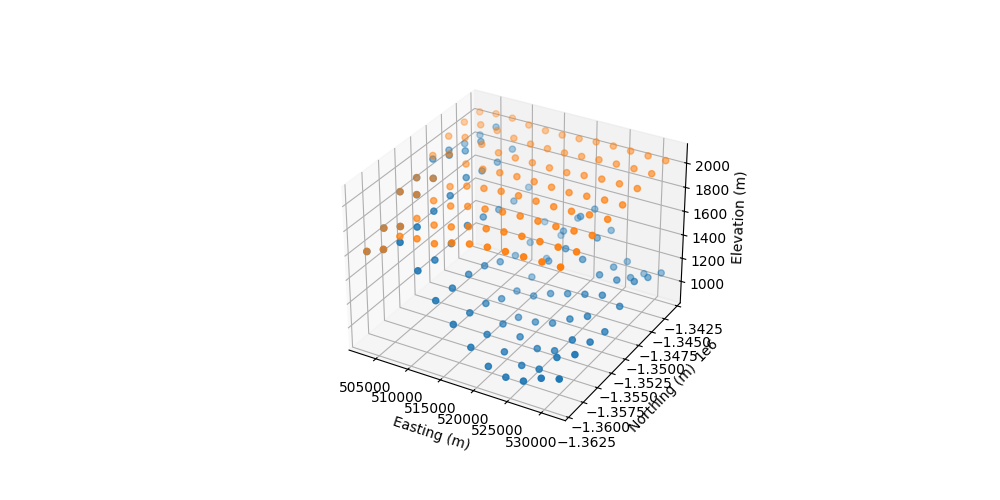

In [3]:
# Load tiff files of the DEMs

src_bed = src_bed_coarse
src_surf = src_surf_coarse

upscale_factor = 1/300


bed_DEM = src_bed.read(1,
                        out_shape=(
                            src_bed.count,
                            int(src_bed.height * upscale_factor),
                            int(src_bed.width * upscale_factor)
                        ),
                        resampling=Resampling.bilinear
                    )

# scale image transform
src_bed_transform = src_bed.transform * src_bed.transform.scale(
    (src_bed.width / bed_DEM.shape[-1]),
    (src_bed.height / bed_DEM.shape[-2])
)


# src_surf = rasterio.open("../Meshes/ThreeD_meshing/rema_large_aoi_align_fixed.tif")

surf_DEM = src_surf.read(1,
                        out_shape=(
                            src_surf.count,
                            int(src_surf.height * upscale_factor),
                            int(src_surf.width * upscale_factor)
                        ),
                        resampling=Resampling.bilinear
                    )

# scale image transform
src_surf_transform = src_surf.transform * src_surf.transform.scale(
    (src_surf.width / surf_DEM.shape[-1]),
    (src_surf.height / surf_DEM.shape[-2])
)

### Check if the bed DEMs is higher than the surface DEM (thickness is negative) ###


thickness = surf_DEM - bed_DEM
thickness[thickness > 0] = 0  # if positive, set to 0. This will mask the negative thickness values
zero_offset = copy.deepcopy(thickness)
zero_offset[zero_offset < 0 ] = -1 # this mask will lower the bed a further 1m in the areas where thickness is negative so the model doesn't crash on a zero.
bed_DEM = bed_DEM + thickness + zero_offset # add the negative values to the bed to push it lower to match the surface DEM



# surf_DEM[surf_DEM==0] = 2000 
# bed_DEM[bed_DEM==-1] = 1999
## Downsample the DEMs if desired
# downsample_factor = 20
# surf_DEM = surf_DEM[::downsample_factor, ::downsample_factor]
# bed_DEM = bed_DEM[::downsample_factor, ::downsample_factor]

height = surf_DEM.shape[0]
width = surf_DEM.shape[1]
cols, rows = np.meshgrid(np.arange(width), np.arange(height))
xs, ys = rasterio.transform.xy(src_surf_transform, rows, cols)
lons= np.array(xs)
lats = np.array(ys)

surf_elevs = surf_DEM.flatten()
bed_elevs = bed_DEM.flatten()

ax = plt.figure(figsize=[10,5]).add_subplot(projection='3d')

ax.scatter(lons, lats, bed_elevs)
ax.scatter(lons, lats, surf_elevs)

ax.set_xlabel('Easting (m)')
ax.set_ylabel('Northing (m)')
ax.set_zlabel('Elevation (m)')

### Load boreholes
borehole_locations = pd.read_csv('../Borehole_Locations/Borehole_locations_DTS.csv')
transformer = Transformer.from_crs("EPSG:4326", "EPSG:3031", always_xy=True)
transformed_x, transformed_y = transformer.transform(borehole_locations['E'], borehole_locations['S'])

### Load image data

with rasterio.open('../imagery/LIMA_virtual_Mosaic_15m.tif') as src1:
    image_data = src1.read()

fig, ax = plt.subplots()
ax.scatter(transformed_x,transformed_y, marker='.',c='red', label='Boreholes')
show(image_data,ax=ax,transform=src1.transform)

width_m = src_surf_transform[0] *surf_DEM.shape[1]
height_m = src_surf_transform[4] *surf_DEM.shape[0]

ax.add_patch(plt.Rectangle((src_surf_transform[2], src_surf_transform[5]),width_m,height_m,  ls='--', ec='black',fc='None'))

### Load the GPS velocities
gps_velocities = pd.read_csv('../GPS_velocities/24-25_velocities-good.csv')

GPS_points = []
for i in gps_velocities.iloc():
    GPS_points.append([i['x'], i['y']])
ax.quiver(gps_velocities['x'], gps_velocities['y'], 
                gps_velocities['u'], gps_velocities['v'], 
                scale = None, label='GPS velocities')

plt.show()

# 1.1 Load the borehole temps

/tmp/ipykernel_1277982/3885655671.py:30: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


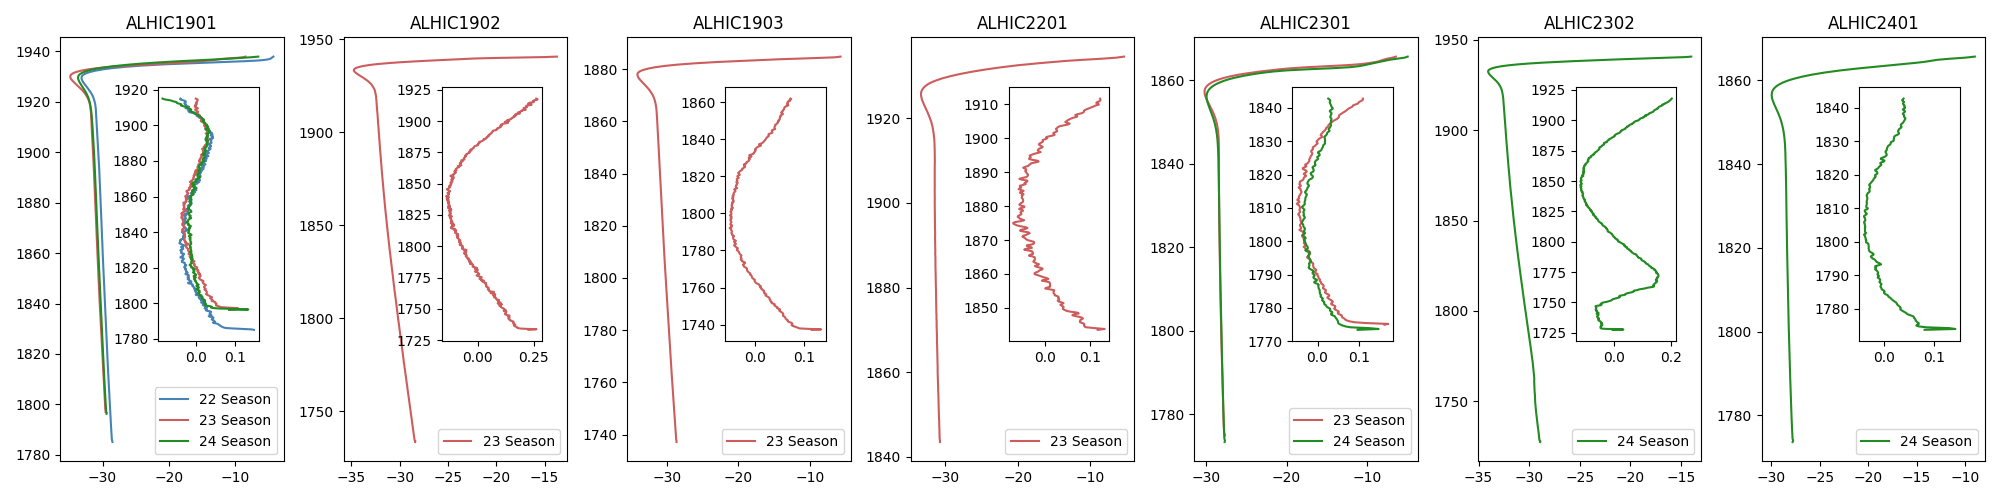

In [4]:
avg_temps = pd.read_pickle('../Borehole_Temps/avg_temps.pkl')
residual_temps = pd.read_pickle('../Borehole_Temps/residual_temps.pkl')

boreholes = ['ALHIC1901', 'ALHIC1902', 'ALHIC1903', 'ALHIC2201', 'ALHIC2301', 'ALHIC2302', 'ALHIC2401']

fig,axes = plt.subplots(1, len(boreholes), figsize=(20, 5))

insets = []
for ax in axes:
    axinses = inset_axes(ax, width = "100%", height = "100%", loc='lower right', bbox_to_anchor=(.5, .25, .45, .60), bbox_transform=ax.transAxes, borderpad=1)
    insets.append(axinses)


for i in avg_temps:
    for borehole, ax, axins in zip(boreholes, axes, insets):

        if i.startswith(borehole):
            if i[-2:] == '22':
                color = 'steelblue'
            elif i[-2:] == '23':
                color = 'indianred'
            elif i[-2:] == '24':
                color = 'forestgreen'
            ax.plot(avg_temps[i][2], avg_temps[i][0], label=i[-2:]+' Season',c=color)
            axins.plot(residual_temps[i][2], residual_temps[i][0], label=i[-2:]+' Season',c=color)
            ax.legend()

            ax.set_title(borehole)

plt.tight_layout()
# plt.savefig('Fig2_borehole_temps.png', dpi=300)

# 2.0 Create the mesh from extrusion

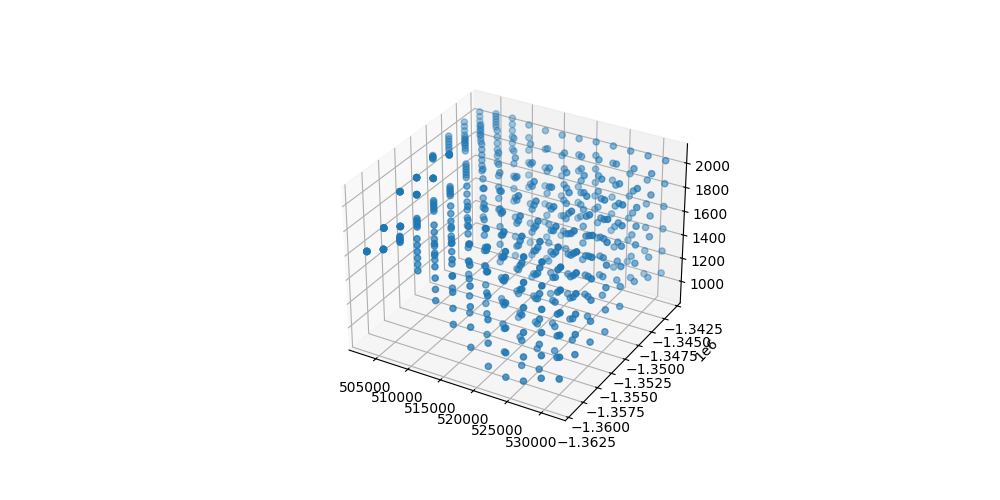

In [5]:
from firedrake import *
from firedrake.__future__ import interpolate

layers = 5 # number of layers in z direction of the extruded mesh
nx = width - 1
ny = height - 1

Lx = lons.max() # x extent, get this from the DEM
Ly = lats.max() # y extent, get this from the DEM

origin_x = lons.min() # origin (lower left corner) in x, get this from the DEM
origin_y = lats.min() # origin (lower left corner) in y, get this from the DEM

base_mesh = RectangleMesh(nx,ny, Lx, Ly, originX=origin_x, originY=origin_y)
# Make a height 1 mesh.
unit_extruded_mesh = ExtrudedMesh(base_mesh, layers=layers)

base_fs = FunctionSpace(base_mesh, "CG", 1)

x,y, = SpatialCoordinate(base_mesh)

# You could set this field any way you like.
## Bed and surface DEM resolution should be nx+1, ny+1 as to match the coordinates of the mesh.

# Now we transfer the bathymetry field into a depth-averaged field.
extruded_element = FiniteElement("R", "interval", 0)
extruded_space = FunctionSpace(unit_extruded_mesh,
                                TensorProductElement(base_fs.ufl_element(),
                                                    extruded_element))


from scipy.interpolate import griddata
## interpolate the DEMs to the mesh coordinates so it is given in the mesh coordinate order
points = np.array([xs,ys]).T # DEM pixel coordinates
xi = base_mesh.coordinates.dat.data_ro[:,:2] # Get the mesh coordinates from the base mesh
surf_interp = griddata(points, surf_DEM.flatten(), xi, method='linear', fill_value=np.nan, rescale=False)
bed_interp = griddata(points, bed_DEM.flatten(), xi, method='linear', fill_value=np.nan, rescale=False)

## Extrude the bed and surface
extruded_bed = Function(extruded_space)
extruded_bed.dat.data_wo[:] = bed_interp

extruded_surface = Function(extruded_space)
extruded_surface.dat.data_wo[:] = surf_interp

# Build a new coordinate field by change of coordinates.
x, y, z = SpatialCoordinate(unit_extruded_mesh)
new_coordinates = assemble(
    interpolate(
        as_vector([x, y, (1-z) * extruded_bed + z * extruded_surface]),
        unit_extruded_mesh.coordinates.function_space()
    )
)


# Finally build the mesh you are actually after.
mesh_src = Mesh(new_coordinates) # Mesh(new_coordinates, tolerance=50)
x_src, y_src, z_src = SpatialCoordinate(mesh_src)

## Plot using scatter since we can't plot Tensor product using triplot
ax = plt.figure(figsize=[10,5]).add_subplot(projection='3d')

ax.scatter(mesh_src.coordinates.dat.data_ro[:,0], mesh_src.coordinates.dat.data_ro[:,1], mesh_src.coordinates.dat.data_ro[:,2])

# 3. Create the FE model

## 3.1 Set up the flow (momentum) space

In [6]:
μ = Constant(5e15) #Ice


pressure_space = firedrake.FunctionSpace(mesh_src, "CG", 1)
velocity_space = firedrake.VectorFunctionSpace(mesh_src, "CG", 3)
Y = velocity_space * pressure_space
flow = firedrake.Function(Y)
u, p = firedrake.split(flow)
v, q = firedrake.TestFunctions(flow.function_space())

τ = 2 * μ * ε(u)
g = as_vector((0, 0, grav))
f =  ρ * g

F_momentum = (inner(τ, ε(v)) - q * div(u) - p * div(v) - inner(f, v)) * dx

## 3.2 Boundary conditions for the flow

In [7]:
face_ids = ['top', 'bottom', 1, 2, 3, 4]

bc_stokes = []
for id in face_ids:
    if id == 'top': pass # Skip the top face for now (free flow)
    else:
        bc = firedrake.DirichletBC(Y.sub(0), as_vector((0, 0, 0)), id) # No flow on the boundaries
        bc_stokes.append(bc)

## 3.3 Do the Stokes solve

In [8]:
basis = firedrake.VectorSpaceBasis(constant=True, comm=firedrake.COMM_WORLD)
nullspace = firedrake.MixedVectorSpaceBasis(Y, [Y.sub(0), basis])

stokes_problem = firedrake.NonlinearVariationalProblem(F_momentum, flow, bc_stokes)
parameters = {
    "nullspace": nullspace,
    "solver_parameters": {
        "ksp_type": "preonly",
        "pc_type": "lu",
        "pc_factor_mat_solver_type": "mumps",
    },
}

stokes_solver = firedrake.NonlinearVariationalSolver(stokes_problem, **parameters)

stokes_solver.solve()

## 3.4 Plot the Stokes solution

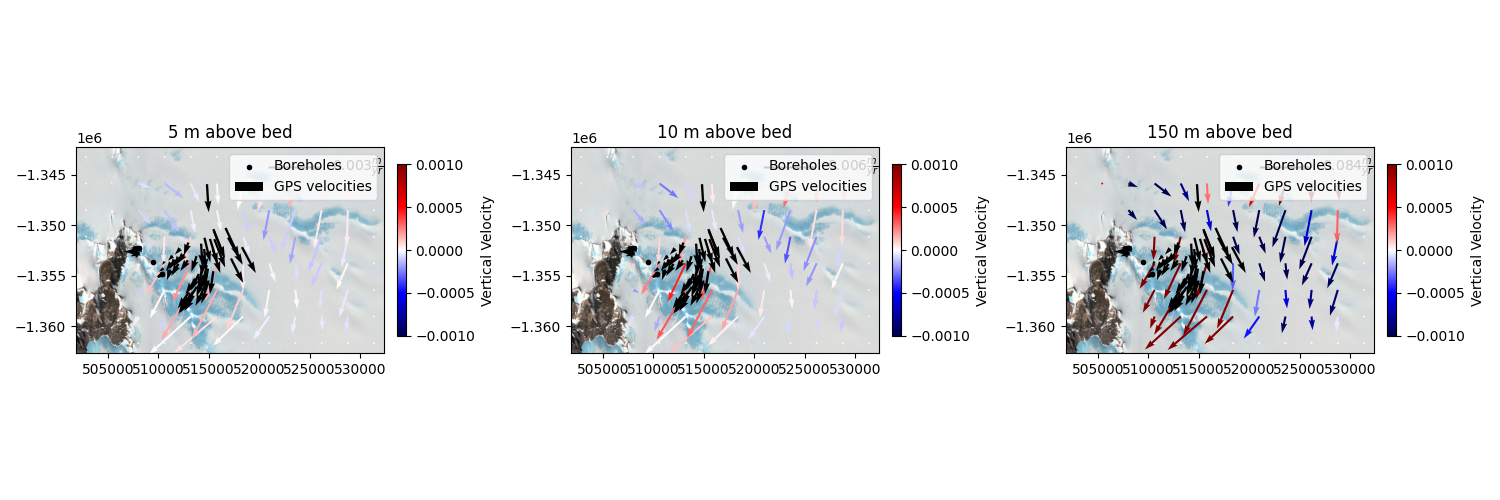

In [9]:
cross_sections = [5,10,150]

fig, axes = plt.subplots(1,len(cross_sections),figsize=[15,5])

for n,m_above_bed in enumerate(cross_sections):
    vel_cross = []
    vel_cross_coords = []

    ### If the DEM includes some nonesense pixels in it, you need this block ##########
    # for x_coord, y_coord, z_coord in zip(xi[:,0], xi[:,1], extruded_bed.dat.data_ro[:]):
    #     if 1998.99 < z_coord < 1999.01:
    #         continue
    #     else:
    #         vel_cross.append(y.at(x_coord, y_coord, z_coord+m_above_bed)[0])
    #         vel_cross_coords.append([x_coord, y_coord, z_coord+m_above_bed])
    #####################################################################################

    ### If the DEM is perfectly rectangular, than you can do this block ####
    for x_coord, y_coord, z_coord in zip(xi[:,0], xi[:,1], extruded_bed.dat.data_ro[:]):
        try:
            vel_cross.append(flow.at(x_coord, y_coord, z_coord+m_above_bed)[0])
            vel_cross_coords.append([x_coord, y_coord, z_coord+m_above_bed])
        except:
            continue

    #########################################


    vel_cross = np.asarray(vel_cross)
    vel_cross_coords = np.asarray(vel_cross_coords)

    norm = mcolors.Normalize(vmin=-0.001, vmax=0.001)
    cmap = plt.cm.seismic
    colors = cmap(norm(vel_cross[:,2]*spy))

    show(image_data,ax=axes[n],transform=src1.transform)
    Q = axes[n].quiver(vel_cross_coords[:,0], vel_cross_coords[:,1], vel_cross[:,0]*spy, vel_cross[:,1]*spy, scale = None, color=colors)

    axes[n].set_xlim([vel_cross_coords[:,0].min()-1000, vel_cross_coords[:,0].max()+1000])
    axes[n].set_ylim([vel_cross_coords[:,1].min()-1000, vel_cross_coords[:,1].max()+1000])

    axes[n].set_title(str(m_above_bed)+' m above bed')
    sm = cm.ScalarMappable(cmap=cmap, norm=norm)
    sm.set_array([])  # Needed only to satisfy colorbar creation
    cbar = plt.colorbar(sm, ax=axes[n], fraction=0.026, pad=0.04)
    cbar.set_label('Vertical Velocity')

    max_val = round(np.max(np.sqrt((vel_cross[:,0]*spy)**2+(vel_cross[:,1]*spy)**2)),3)
    axes[n].scatter(transformed_x,transformed_y, marker='.',color='black', label='Boreholes')
    max_val_str = str(max_val)
    qk = axes[n].quiverkey(Q, 0.8, 0.9, max_val, max_val_str+r'$\frac{m}{yr}$', labelpos='E', coordinates='axes', color='black')
    axes[n].quiver(gps_velocities['x'], gps_velocities['y'], 
                   gps_velocities['u'], gps_velocities['v'], 
                   scale = None, label='GPS velocities')
    axes[n].legend()

plt.tight_layout()
# plt.savefig('3d_flow_cross_sections_long.png', dpi=300)

# 4. Interpolate this stokes solution onto a new mesh

## 4.0 Take the unit extruded mesh to map the flow field on (ie from 0 - 1)

- Here, I am just defining intermediate function spaces as defined by the "_coarse_norm" tag

In [10]:
pressure_space_coarse_norm = firedrake.FunctionSpace(unit_extruded_mesh, "CG", 1)
velocity_space_coarse_norm = firedrake.VectorFunctionSpace(unit_extruded_mesh, "CG", 3)
Y_coarse_norm = velocity_space_coarse_norm * pressure_space_coarse_norm
flow_coarse_norm = firedrake.Function(Y_coarse_norm)

## 4.0.1 Here, I am mapping the flow field we just calculated onto the coarse mesh that now is normed in elevation (ie from 0-1)

In [11]:
flow_coarse_norm.sub(0).dat.data[:] = flow.sub(0).dat.data_ro
flow_coarse_norm.sub(1).dat.data[:] = flow.sub(1).dat.data_ro

## 4.1 Here let's make the fine mesh in normed vertical coordinates

### 4.1.0 Load the fine mesh and plot

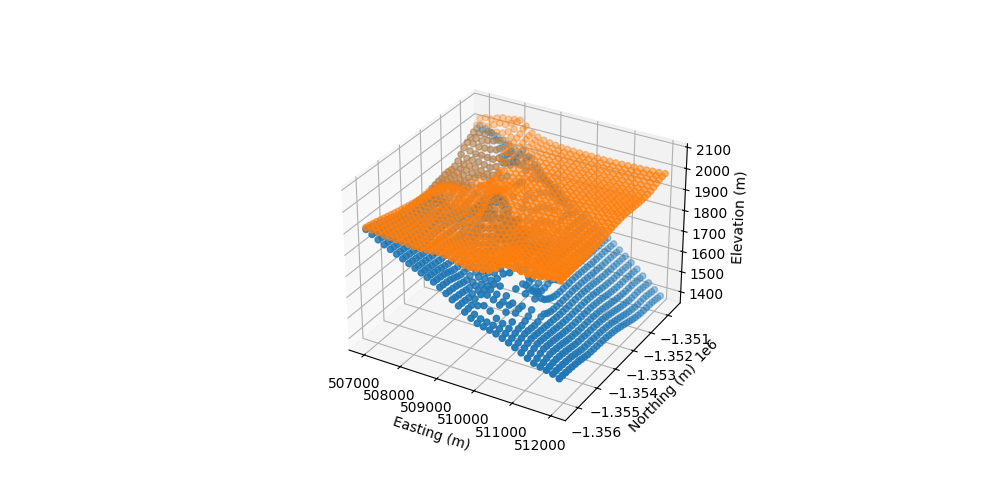

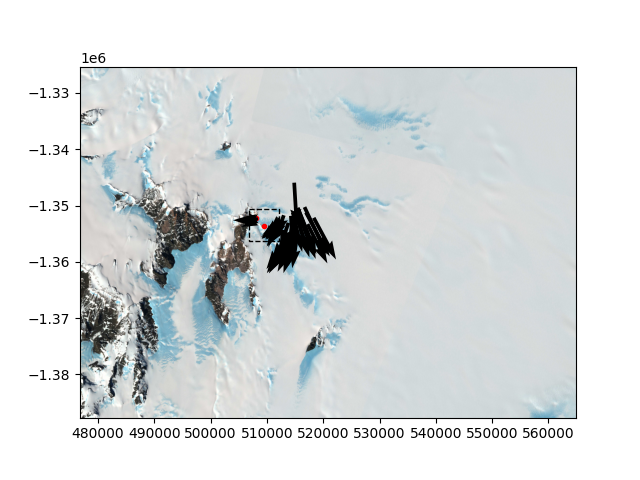

In [13]:
# Load tiff files of the DEMs

src_bed = src_bed_fine
src_surf = src_surf_fine

upscale_factor = 1/20


bed_DEM = src_bed.read(1,
                        out_shape=(
                            src_bed.count,
                            int(src_bed.height * upscale_factor),
                            int(src_bed.width * upscale_factor)
                        ),
                        resampling=Resampling.bilinear
                    )

# scale image transform
src_bed_transform = src_bed.transform * src_bed.transform.scale(
    (src_bed.width / bed_DEM.shape[-1]),
    (src_bed.height / bed_DEM.shape[-2])
)


# src_surf = rasterio.open("../Meshes/ThreeD_meshing/rema_large_aoi_align_fixed.tif")

surf_DEM = src_surf.read(1,
                        out_shape=(
                            src_surf.count,
                            int(src_surf.height * upscale_factor),
                            int(src_surf.width * upscale_factor)
                        ),
                        resampling=Resampling.bilinear
                    )

# scale image transform
src_surf_transform = src_surf.transform * src_surf.transform.scale(
    (src_surf.width / surf_DEM.shape[-1]),
    (src_surf.height / surf_DEM.shape[-2])
)

### Check if the bed DEMs is higher than the surface DEM (thickness is negative) ###


thickness = surf_DEM - bed_DEM
thickness[thickness > 0] = 0  # if positive, set to 0. This will mask the negative thickness values
zero_offset = copy.deepcopy(thickness)
zero_offset[zero_offset < 0 ] = -1 # this mask will lower the bed a further 1m in the areas where thickness is negative so the model doesn't crash on a zero.
bed_DEM = bed_DEM + thickness + zero_offset # add the negative values to the bed to push it lower to match the surface DEM



# surf_DEM[surf_DEM==0] = 2000 
# bed_DEM[bed_DEM==-1] = 1999
## Downsample the DEMs if desired
# downsample_factor = 20
# surf_DEM = surf_DEM[::downsample_factor, ::downsample_factor]
# bed_DEM = bed_DEM[::downsample_factor, ::downsample_factor]

height = surf_DEM.shape[0]
width = surf_DEM.shape[1]
cols, rows = np.meshgrid(np.arange(width), np.arange(height))
xs, ys = rasterio.transform.xy(src_surf_transform, rows, cols)
lons= np.array(xs)
lats = np.array(ys)

surf_elevs = surf_DEM.flatten()
bed_elevs = bed_DEM.flatten()

ax = plt.figure(figsize=[10,5]).add_subplot(projection='3d')

ax.scatter(lons, lats, bed_elevs)
ax.scatter(lons, lats, surf_elevs)

ax.set_xlabel('Easting (m)')
ax.set_ylabel('Northing (m)')
ax.set_zlabel('Elevation (m)')

### Load boreholes
borehole_locations = pd.read_csv('../Borehole_Locations/Borehole_locations_DTS.csv')
transformer = Transformer.from_crs("EPSG:4326", "EPSG:3031", always_xy=True)
transformed_x, transformed_y = transformer.transform(borehole_locations['E'], borehole_locations['S'])

### Load image data

with rasterio.open('../imagery/LIMA_virtual_Mosaic_15m.tif') as src1:
    image_data = src1.read()

fig, ax = plt.subplots()
ax.scatter(transformed_x,transformed_y, marker='.',c='red', label='Boreholes')
show(image_data,ax=ax,transform=src1.transform)

width_m = src_surf_transform[0] *surf_DEM.shape[1]
height_m = src_surf_transform[4] *surf_DEM.shape[0]

ax.add_patch(plt.Rectangle((src_surf_transform[2], src_surf_transform[5]),width_m,height_m,  ls='--', ec='black',fc='None'))

### Load the GPS velocities
gps_velocities = pd.read_csv('../GPS_velocities/24-25_velocities-good.csv')

GPS_points = []
for i in gps_velocities.iloc():
    GPS_points.append([i['x'], i['y']])
ax.quiver(gps_velocities['x'], gps_velocities['y'], 
                gps_velocities['u'], gps_velocities['v'], 
                scale = None, label='GPS velocities')

## 4.1.1 Make the fine mesh with a unit height (like we did for the coarse mesh)

In [14]:
from firedrake import *
from firedrake.__future__ import interpolate

layers = 5 # number of layers in z direction of the extruded mesh
nx = width - 1
ny = height - 1

Lx = lons.max() # x extent, get this from the DEM
Ly = lats.max() # y extent, get this from the DEM

origin_x = lons.min() # origin (lower left corner) in x, get this from the DEM
origin_y = lats.min() # origin (lower left corner) in y, get this from the DEM

base_mesh = RectangleMesh(nx,ny, Lx, Ly, originX=origin_x, originY=origin_y)
# Make a height 1 mesh.
unit_extruded_mesh = ExtrudedMesh(base_mesh, layers=layers)

xi = base_mesh.coordinates.dat.data_ro[:,:2] # Get the mesh coordinates from the base mesh

## 4.1.2 Now, we make the velocity / pressure function spaces for the fine mesh

In [15]:
pressure_space_fine_norm = firedrake.FunctionSpace(unit_extruded_mesh, "CG", 1)
velocity_space_fine_norm = firedrake.VectorFunctionSpace(unit_extruded_mesh, "CG", 3)
Y_fine_norm = velocity_space_fine_norm * pressure_space_fine_norm


## 4.1.3 Now, interpolate the coarse mesh flow field onto the fine mesh flow field

In [16]:
flow_fine_interp = assemble(interpolate(flow_coarse_norm, Function(Y_fine_norm)))

### 4.1.3.1 Plot the interpolated flow field

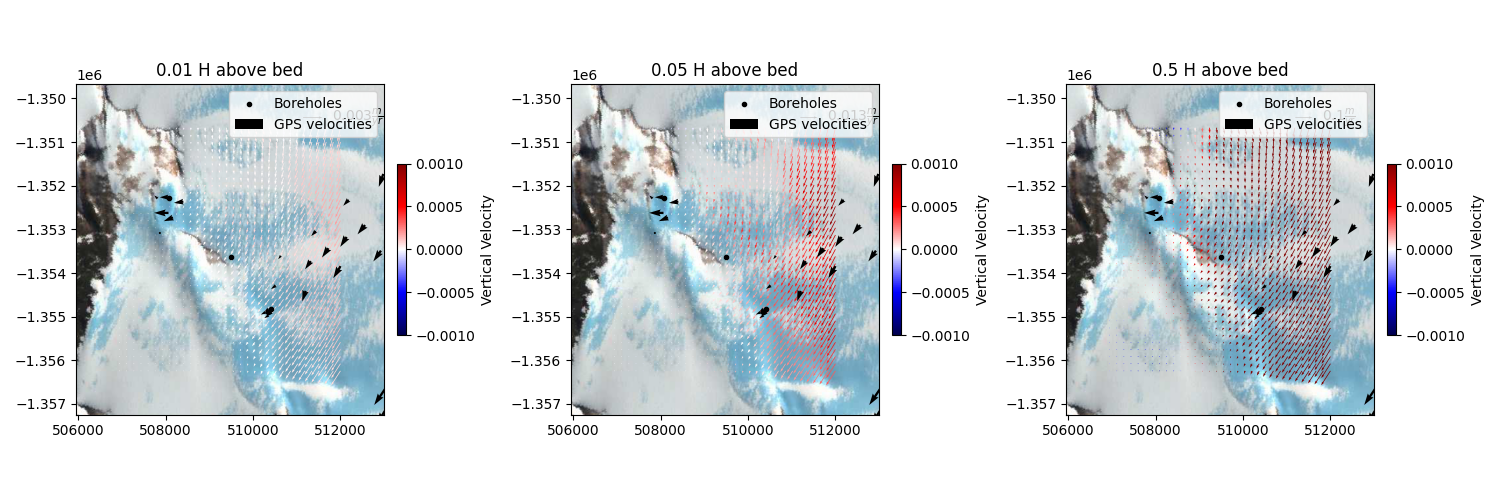

In [17]:
cross_sections = [.01,.05,.5]

fig, axes = plt.subplots(1,len(cross_sections),figsize=[15,5])

for n,m_above_bed in enumerate(cross_sections):
    vel_cross = []
    vel_cross_coords = []

    ### If the DEM includes some nonesense pixels in it, you need this block ##########
    # for x_coord, y_coord, z_coord in zip(xi[:,0], xi[:,1], extruded_bed.dat.data_ro[:]):
    #     if 1998.99 < z_coord < 1999.01:
    #         continue
    #     else:
    #         vel_cross.append(y.at(x_coord, y_coord, z_coord+m_above_bed)[0])
    #         vel_cross_coords.append([x_coord, y_coord, z_coord+m_above_bed])
    #####################################################################################

    ### If the DEM is perfectly rectangular, than you can do this block ####
    for x_coord, y_coord, z_coord in zip(xi[:,0], xi[:,1], np.array([0]*len(xi))):
        try:
            vel_cross.append(flow_fine_interp.at(x_coord, y_coord, z_coord+m_above_bed)[0])
            vel_cross_coords.append([x_coord, y_coord, z_coord+m_above_bed])
        except:
            continue

    #########################################


    vel_cross = np.asarray(vel_cross)
    vel_cross_coords = np.asarray(vel_cross_coords)

    norm = mcolors.Normalize(vmin=-0.001, vmax=0.001)
    cmap = plt.cm.seismic
    colors = cmap(norm(vel_cross[:,2]*spy))

    show(image_data,ax=axes[n],transform=src1.transform)
    Q = axes[n].quiver(vel_cross_coords[:,0], vel_cross_coords[:,1], vel_cross[:,0]*spy, vel_cross[:,1]*spy, scale = None, color=colors)

    axes[n].set_xlim([vel_cross_coords[:,0].min()-1000, vel_cross_coords[:,0].max()+1000])
    axes[n].set_ylim([vel_cross_coords[:,1].min()-1000, vel_cross_coords[:,1].max()+1000])

    axes[n].set_title(str(m_above_bed)+' H above bed')
    sm = cm.ScalarMappable(cmap=cmap, norm=norm)
    sm.set_array([])  # Needed only to satisfy colorbar creation
    cbar = plt.colorbar(sm, ax=axes[n], fraction=0.026, pad=0.04)
    cbar.set_label('Vertical Velocity')

    max_val = round(np.max(np.sqrt((vel_cross[:,0]*spy)**2+(vel_cross[:,1]*spy)**2)),3)
    axes[n].scatter(transformed_x,transformed_y, marker='.',color='black', label='Boreholes')
    max_val_str = str(max_val)
    qk = axes[n].quiverkey(Q, 0.8, 0.9, max_val, max_val_str+r'$\frac{m}{yr}$', labelpos='E', coordinates='axes', color='black')
    axes[n].quiver(gps_velocities['x'], gps_velocities['y'], 
                   gps_velocities['u'], gps_velocities['v'], 
                   scale = None, label='GPS velocities')
    axes[n].legend()

plt.tight_layout()

## 4.2 Now make the fine mesh

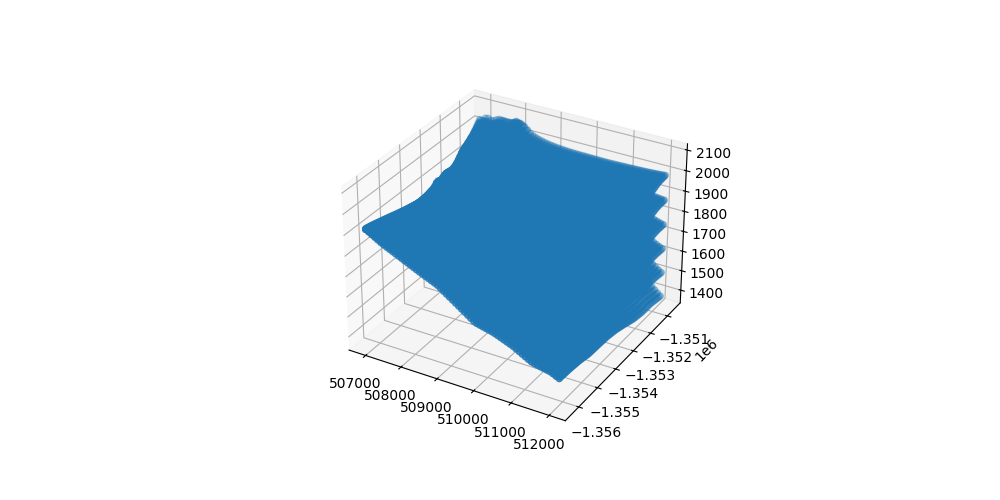

In [94]:
base_fs = FunctionSpace(base_mesh, "CG", 1)

x,y, = SpatialCoordinate(base_mesh)

# You could set this field any way you like.
## Bed and surface DEM resolution should be nx+1, ny+1 as to match the coordinates of the mesh.

# Now we transfer the bathymetry field into a depth-averaged field.
extruded_element = FiniteElement("R", "interval", 0)
extruded_space = FunctionSpace(unit_extruded_mesh,
                                TensorProductElement(base_fs.ufl_element(),
                                                    extruded_element))


from scipy.interpolate import griddata
## interpolate the DEMs to the mesh coordinates so it is given in the mesh coordinate order
points = np.array([xs,ys]).T # DEM pixel coordinates
xi = base_mesh.coordinates.dat.data_ro[:,:2] # Get the mesh coordinates from the base mesh
surf_interp = griddata(points, surf_DEM.flatten(), xi, method='linear', fill_value=np.nan, rescale=False)
bed_interp = griddata(points, bed_DEM.flatten(), xi, method='linear', fill_value=np.nan, rescale=False)

## Extrude the bed and surface
extruded_bed = Function(extruded_space)
extruded_bed.dat.data_wo[:] = bed_interp

extruded_surface = Function(extruded_space)
extruded_surface.dat.data_wo[:] = surf_interp

# Build a new coordinate field by change of coordinates.
x, y, z = SpatialCoordinate(unit_extruded_mesh)
new_coordinates = assemble(
    interpolate(
        as_vector([x, y, (1-z) * extruded_bed + z * extruded_surface]),
        unit_extruded_mesh.coordinates.function_space()
    )
)


# Finally build the mesh you are actually after.
mesh_fine = Mesh(new_coordinates) # Mesh(new_coordinates, tolerance=50)
x_fine, y_fine, z_fine = SpatialCoordinate(mesh_fine)

## Plot using scatter since we can't plot Tensor product using triplot
ax = plt.figure(figsize=[10,5]).add_subplot(projection='3d')

ax.scatter(mesh_fine.coordinates.dat.data_ro[:,0], mesh_fine.coordinates.dat.data_ro[:,1], mesh_fine.coordinates.dat.data_ro[:,2])

# 5. Set up the FE model

## 5.1 Make the flow function space

In [96]:
μ = Constant(5e15) #Ice


pressure_space = firedrake.FunctionSpace(mesh_fine, "CG", 1)
velocity_space = firedrake.VectorFunctionSpace(mesh_fine, "CG", 3)
Y = velocity_space * pressure_space
flow = firedrake.Function(Y)
u, p = firedrake.split(flow)
v, q = firedrake.TestFunctions(flow.function_space())

τ = 2 * μ * ε(u)
g = as_vector((0, 0, grav))
f =  ρ * g

F_momentum = (inner(τ, ε(v)) - q * div(u) - p * div(v) - inner(f, v)) * dx

## 5.2 Do the boundary conditions. Here we will take the interpolated flow field

In [99]:
flow_fine_interp.sub(0).dat.data_ro

array([[ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       [ 6.23823135e-13, -3.20712675e-12, -4.53542172e-13],
       [ 1.57022924e-12, -8.01147962e-12, -1.24375396e-12],
       ...,
       [-6.69169366e-10, -3.27586804e-09,  2.22681966e-10],
       [-6.80694133e-10, -3.33067413e-09,  2.40360721e-10],
       [-6.83024479e-10, -3.33810870e-09,  2.51078488e-10]],
      shape=(651568, 3))

In [ ]:
face_ids = ['top', 'bottom', 1, 2, 3, 4]

bc_stokes = []
for id in face_ids:
    if id == 'top': pass # Skip the top face for now (free flow)
    else:
        bc = firedrake.DirichletBC(Y.sub(0), flow_fine_interp.sub(0).dat.data_ro, id) # No flow on the boundaries
        bc_stokes.append(bc)

## 4.2 Create the function spaces of the fine mesh to interpolate onto

In [13]:
pressure_space_dest = firedrake.FunctionSpace(mesh_dest, "CG", 1)
velocity_space_dest = firedrake.VectorFunctionSpace(mesh_dest, "CG", 3)
Y_dest = velocity_space_dest * pressure_space_dest
flow_dest = firedrake.Function(Y_dest)

flow_dest_interp = assemble(interpolate(flow, flow_dest))

DofNotDefinedError: The given target function space on domain Mesh(VectorElement(TensorProductElement(FiniteElement('Lagrange', triangle, 1), FiniteElement('Lagrange', interval, 1), cell=TensorProductCell(triangle, interval)), dim=3), 33) contains degrees of freedom which cannot cannot be defined in the source function space on domain Mesh(VectorElement(TensorProductElement(FiniteElement('Lagrange', triangle, 1), FiniteElement('Lagrange', interval, 1), cell=TensorProductCell(triangle, interval)), dim=3), 8). This may be because the target mesh covers a larger domain than the source mesh. To disable this error, set allow_missing_dofs=True.

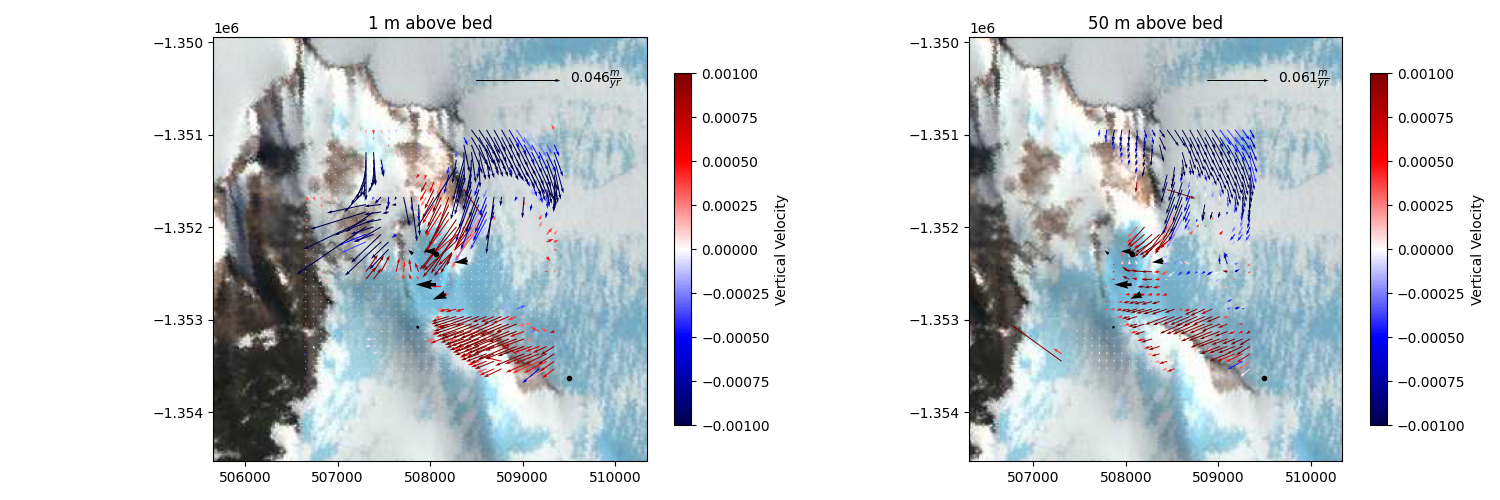

In [15]:
cross_sections = [1,50]

fig, axes = plt.subplots(1,len(cross_sections),figsize=[15,5])

for n,m_above_bed in enumerate(cross_sections):
    vel_cross = []
    vel_cross_coords = []

    ### If the DEM includes some nonesense pixels in it, you need this block ##########
    # for x_coord, y_coord, z_coord in zip(xi[:,0], xi[:,1], extruded_bed.dat.data_ro[:]):
    #     if 1998.99 < z_coord < 1999.01:
    #         continue
    #     else:
    #         vel_cross.append(y.at(x_coord, y_coord, z_coord+m_above_bed)[0])
    #         vel_cross_coords.append([x_coord, y_coord, z_coord+m_above_bed])
    #####################################################################################

    ### If the DEM is perfectly rectangular, than you can do this block ####
    for x_coord, y_coord, z_coord in zip(xi[:,0], xi[:,1], extruded_bed.dat.data_ro[:]):
        try:
            vel_cross.append(flow_dest_interp.at(x_coord, y_coord, z_coord+m_above_bed)[0])
            vel_cross_coords.append([x_coord, y_coord, z_coord+m_above_bed])
        except:
            continue

    #########################################


    vel_cross = np.asarray(vel_cross)
    vel_cross_coords = np.asarray(vel_cross_coords)

    norm = mcolors.Normalize(vmin=-0.001, vmax=0.001)
    cmap = plt.cm.seismic
    colors = cmap(norm(vel_cross[:,2]*spy))

    show(image_data,ax=axes[n],transform=src1.transform)
    Q = axes[n].quiver(vel_cross_coords[:,0], vel_cross_coords[:,1], vel_cross[:,0]*spy, vel_cross[:,1]*spy, scale = None, color=colors)

    axes[n].set_xlim([vel_cross_coords[:,0].min()-1000, vel_cross_coords[:,0].max()+1000])
    axes[n].set_ylim([vel_cross_coords[:,1].min()-1000, vel_cross_coords[:,1].max()+1000])

    axes[n].set_title(str(m_above_bed)+' m above bed')
    sm = cm.ScalarMappable(cmap=cmap, norm=norm)
    sm.set_array([])  # Needed only to satisfy colorbar creation
    cbar = plt.colorbar(sm, ax=axes[n], fraction=0.026, pad=0.04)
    cbar.set_label('Vertical Velocity')

    max_val = round(np.max(np.sqrt((vel_cross[:,0]*spy)**2+(vel_cross[:,1]*spy)**2)),3)
    axes[n].scatter(transformed_x,transformed_y, marker='.',color='black', label='Boreholes')
    max_val_str = str(max_val)
    qk = axes[n].quiverkey(Q, 0.8, 0.9, max_val, max_val_str+r'$\frac{m}{yr}$', labelpos='E', coordinates='axes', color='black')
    axes[n].quiver(gps_velocities['x'], gps_velocities['y'], 
                   gps_velocities['u'], gps_velocities['v'], 
                   scale = None, label='GPS velocities')
    #axes[n].legend()

plt.tight_layout()
# plt.savefig('3d_flow_cross_sections_long.png', dpi=300)

## Notes from Dan

- Put the fine mesh into normalized depths (from 0 (bed) - 1 (surface)) as well as the coarse mesh and then use that to map to one another